In [1]:
from scripts.import_file import *

# 准备数据

In [2]:
df13 = pd.read_pickle('./data/grouped_13.df')
df14 = pd.read_pickle('./data/grouped_14.df')

In [ ]:
y13 = df13.pop('Yield')
y14 = df14.pop('Yield')

In [ ]:
X13 = df13.drop('Location', axis=1)
X14 = df14.drop('Location', axis=1)

In [ ]:
# reshape 901*186*16
def reshape_data(df):
    """
    reshape data to 901*16*186
    """
    res = []
    for row in df:
        new_row = []
        for col in row:
            new_row.append(col)
        res.append(new_row)
    return res

# 重绘地图

In [3]:
yd_loc = df13[['Location', 'Yield']]

In [43]:
def make_heat_map(yd_loc):
    heat_map_data = []
    for row in yd_loc.values:
        row_data = []
        row_data.append(row[0][1])
        row_data.append(row[0][0])
        row_data.append(row[1])
        heat_map_data.append(row_data)
    return heat_map_data
hemap_data = make_heat_map(yd_loc)

In [44]:
hemap_data[0]

[45.8405591, -120.9140928, 43.699999999999875]

In [49]:
import folium
from folium.plugins import HeatMap

m = folium.Map(
    location=[39.9, -101],
    zoom_start=4,
    zoom_control=False,
    tiles='http://webrd02.is.autonavi.com/appmaptile?lang=en&size=1&scale=1&style=8&x={x}&y={y}&z={z}',
    attr="""&copy; <a href="http://ditu.amap.com/">高德地图</a>"""
    )
# m = folium.Map(location=[39.9, -101], zoom_start=4, zoom_control=False, width='70%',height='70%')

HeatMap(hemap_data).add_to(m)

# 模型

In [2]:
L2 = keras.regularizers.l2(1e-4)
model = keras.models.Sequential(name="yield_pre")
model.add(layers.Input(shape=(186, 16), name='input'))
model.add(
    layers.Bidirectional(
        layers.LSTM(32, 
                   kernel_regularizer=L2,
                   recurrent_regularizer=L2,
                   bias_regularizer=L2,
                   recurrent_initializer='glorot_uniform',
                   return_sequences=True,
                   name='LSTM-1'),
        merge_mode='concat',
        name='Bid-1'
    )
)
model.add(
    layers.Bidirectional(
        layers.LSTM(32, 
                   kernel_regularizer=L2,
                   recurrent_regularizer=L2,
                   bias_regularizer=L2,
                   recurrent_initializer='glorot_uniform',
                   return_sequences=True,
                   name='LSTM-2'),
        merge_mode='concat',
        name='Bid-2'
    )
)
model.add(
    layers.Bidirectional(
        layers.LSTM(32, 
                   kernel_regularizer=L2,
                   recurrent_regularizer=L2,
                   bias_regularizer=L2,
                   recurrent_initializer='glorot_uniform',
                   return_sequences=False,
                   name='LSTM-3'),
        merge_mode='concat',
        name='Bid-3'
    )
)
model.add(layers.Dense(1, name='output'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

In [ ]:
model.summary()

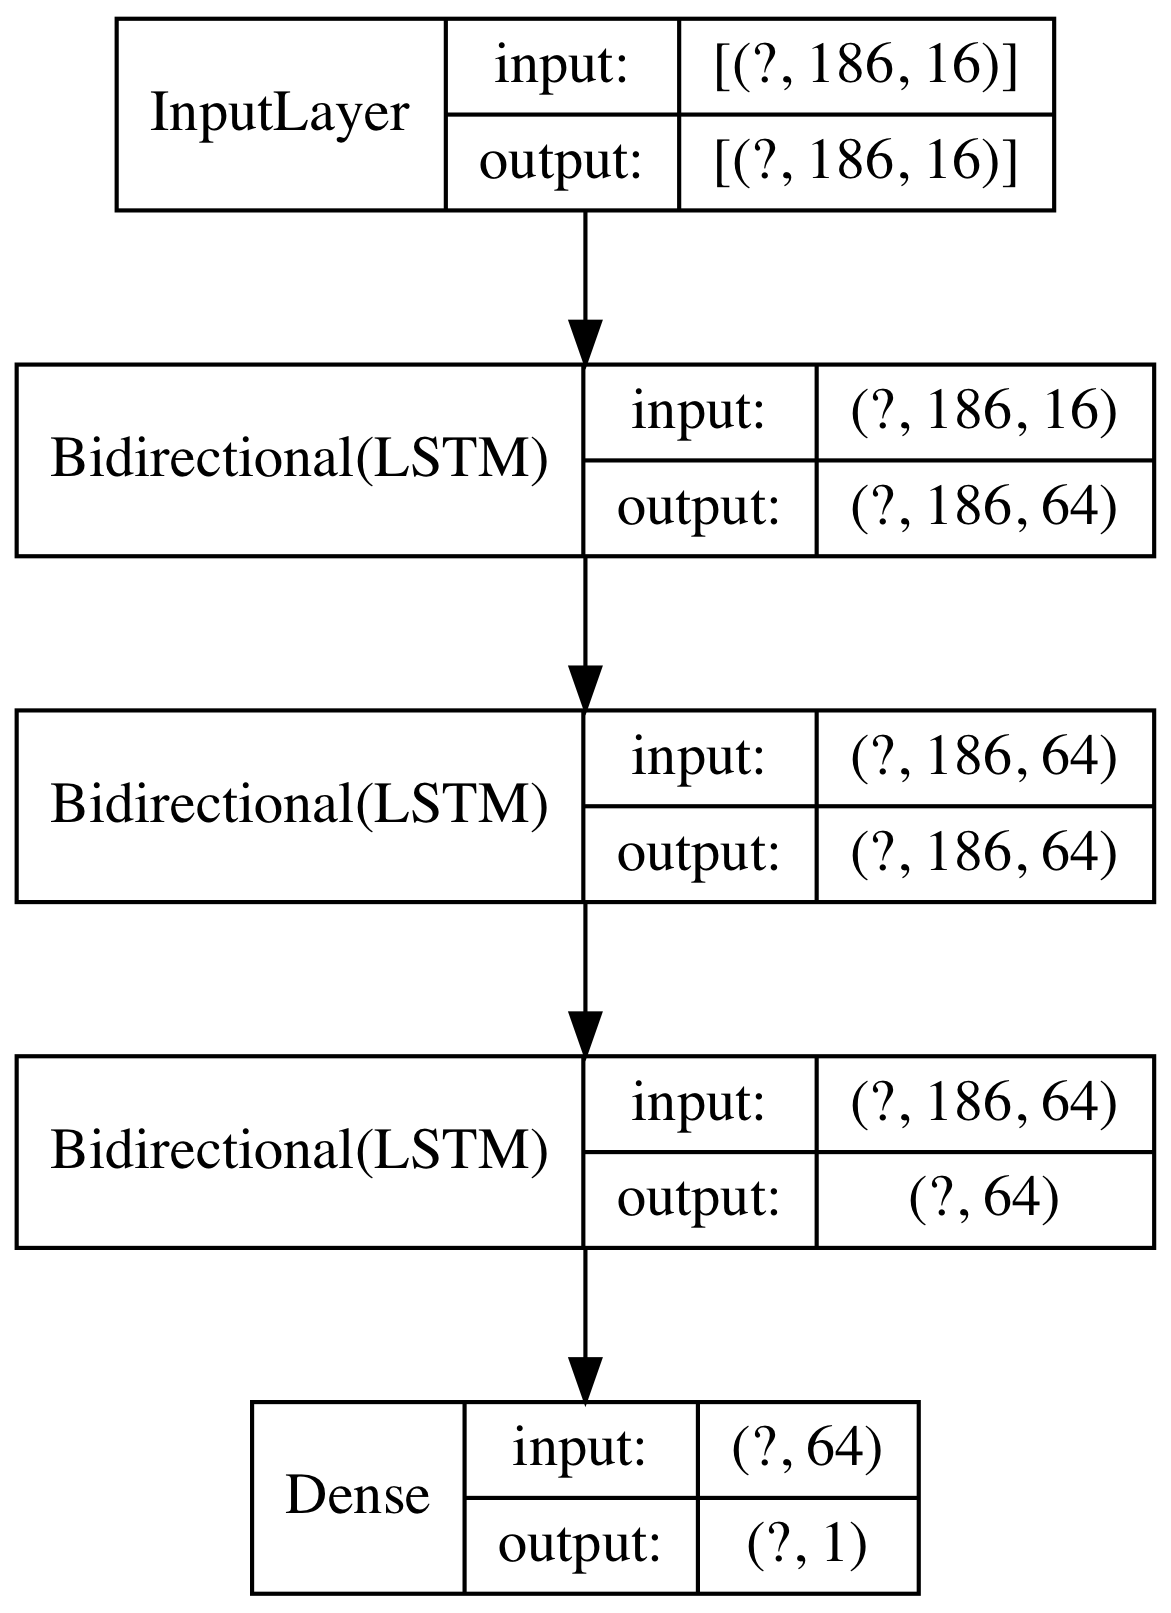

In [3]:
keras.utils.plot_model(model,show_shapes=True, show_layer_names=False, to_file='./Latex/figures/Model_figure.png', dpi=300)